# I had to write a separate code for log-linear because in the natural theta(c,q) and alpha(q) coordinates the machine precision could not keep up with the exponentials. 

# So I switched to different coordinates: log(100)+ w log q - log c, and q

# The rest is just like in the code for linear

In [1]:
print("listing package versions... ")
import sys
print("python:", sys.version)
import pickle as pkl
import seaborn as sns
print("seaborn:", sns.__version__)
import matplotlib as mpl
import matplotlib.pyplot as plt
print("matplotlib:", mpl.__version__)
import numpy as np
print("numpy:", np.__version__)
import numba as nb
print("numba:", nb.__version__)
import scipy as sp
import scipy.integrate as sp1
import scipy.interpolate as sp2
import scipy.misc as sp3
import scipy.optimize as sp4
print("scipy:", sp.__version__)
import os
from pathlib import Path
%matplotlib inline

listing package versions... 
python: 3.7.0 (default, Jun 28 2018, 07:39:16) 
[Clang 4.0.1 (tags/RELEASE_401/final)]
seaborn: 0.9.0
matplotlib: 2.2.3
numpy: 1.15.1
numba: 0.39.0
scipy: 1.1.0


In [2]:
mpl.rcParams['figure.dpi'] = 100
mpl.rcParams['figure.figsize'] = 8,8

sns.set_context("paper")
sns.set(font='serif')
sns.set_style("white", {
        "font.family": "serif",
        "font.serif": ["Times", "Palatino", "serif"]})

pardir=Path(os.getcwd()).parent.parent
datadir=str(pardir) +'/Data'

mycmap=sns.cubehelix_palette(n_colors=50, start=1, rot=4, light=0.7, dark=0)

In [3]:
# my homebrew 2d interpolation function
@nb.autojit(nopython=True)
def int2d(x,y,matrix):
    a,b=matrix.shape
    left=np.int(min(max(np.int(x),0),a-2))
    right=left+1
    bottom=np.int(min(max(np.int(y),0),b-2))
    top=bottom+1
    x=right-x
    y=top-y
    return x*y*matrix[left,bottom]+(1-x)*y*matrix[right,bottom]+x*(1-y)*matrix[left,top]+(1-x)*(1-y)*matrix[right,top]

# this copy to pass into the integrator (scipy won't take the raw function)
@nb.autojit()
def int2dslow(x,y,matrix):
    a,b=matrix.shape
    left=np.int(min(max(np.int(x),0),a-2))
    right=left+1
    bottom=np.int(min(max(np.int(y),0),b-2))
    top=bottom+1
    x=right-x
    y=top-y
    return x*y*matrix[left,bottom]+(1-x)*y*matrix[right,bottom]+x*(1-y)*matrix[left,top]+(1-x)*(1-y)*matrix[right,top]

In [4]:
industry="sci"
weight="55"

fc=8

mydir=datadir+"/derive/"+industry+weight+"/"
[PART,DATA]=pkl.load(open(datadir+'/derive/'+industry+weight+"j.pkl", "rb"))
dist_rmcq=pkl.load(open(mydir+industry+weight+"j_rcmq_"+str(fc)+".pkl", "rb"))

In [5]:
mpl.rcParams['figure.figsize'] = 8,8

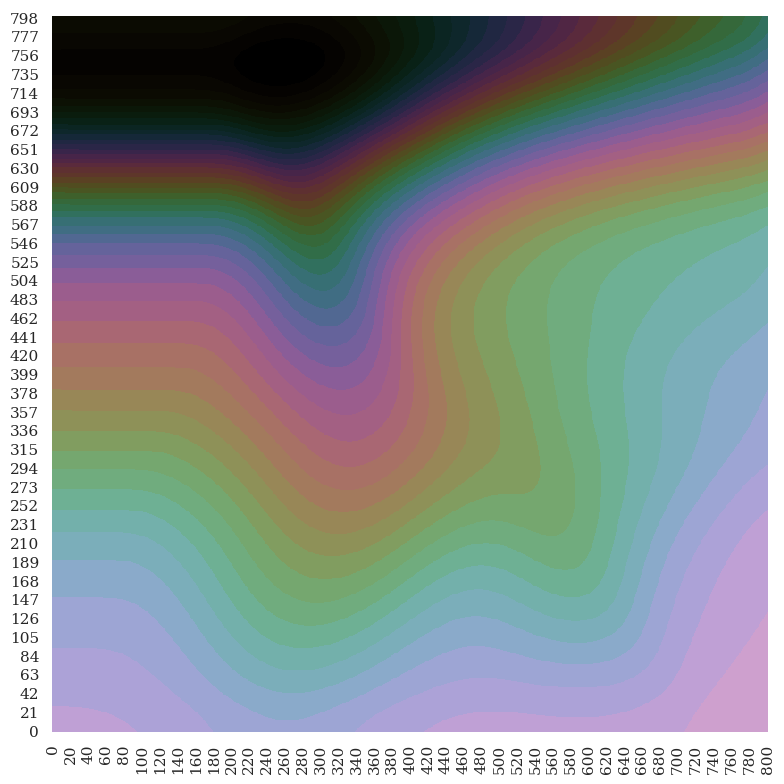

In [6]:
ax=sns.heatmap(dist_rmcq, cmap=mycmap, cbar=0, square=1)
ax.invert_yaxis()
plt.tight_layout()

In [7]:
powr=np.array(PART[0])
freq=np.array(PART[1])
freq=freq/np.sum(freq)

In [8]:
w=450
w=w/1000


design='loglinear'
scale=20
right=int(round(fc*scale*(w+1)*np.log(100)))
dist_qth=np.zeros((100*fc+1,right),dtype=float)

boundary1=[fc*np.exp((j/(fc*scale)-np.log(100))/w) for j in range(0,right)]
boundary2=[fc*np.exp((j/(fc*scale))/w) for j in range(0,right)]

def create_qth(dist_qth,dist_rmcq,right,fc,w,scale): 
    for i in range(1,100*fc+1):
        q=i/fc
        for j in range(0,right):    
            th=j/(fc*scale)
            c=np.exp(-th+w*np.log(q)+np.log(100))
            rmc=100-c
            jac=c
            if rmc>=0 and rmc <=99:
                dist_qth[i,j]=int2d(i,rmc*fc,dist_rmcq)*jac
            
create_qth(dist_qth,dist_rmcq,right,fc,w,scale)
dist_qth=fc*fc*scale*dist_qth/np.sum(dist_qth)

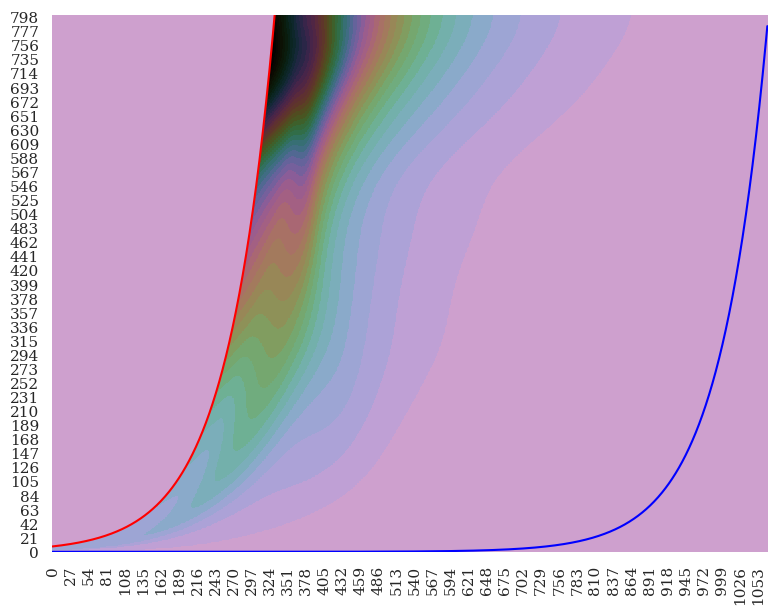

In [9]:
ax=sns.heatmap(dist_qth, cmap=mycmap, cbar=0, square=1)
ax.invert_yaxis()
plt.plot(range(0,right), boundary1, '-', markersize=1, color= 'blue')
plt.plot(range(0,right), boundary2, '-', markersize=1, color= 'red')
plt.tight_layout()

In [10]:
@nb.autojit(nopython=True)
def create1(Fp1,right,fc): 
    for j in range(0,right):
        for i in range(0,100*fc):
            Fp1[i+1,j]+=Fp1[i,j]

@nb.autojit(nopython=True)
def create2(Fp2,right,fc): 
    for i in range(0,100*fc+1):
        for j in range(0,right-1):
            Fp2[i,j+1]+=Fp2[i,j]

@nb.autojit(nopython=True)
def create0(F,right,fc): 
    for i in range(0,100*fc+1):
        for j in range(0,right-1):
            F[i,j+1]+=F[i,j]

In [11]:
#do not rescale these, it's important
Fp1=dist_qth.copy(); create1(Fp1,right,fc)
Fp2=dist_qth.copy(); create2(Fp2,right,fc)
F=Fp1.copy(); create0(F,right,fc)
print('this is one:', np.max(F/(fc*fc*scale)))

this is one: 1.0000000000000002


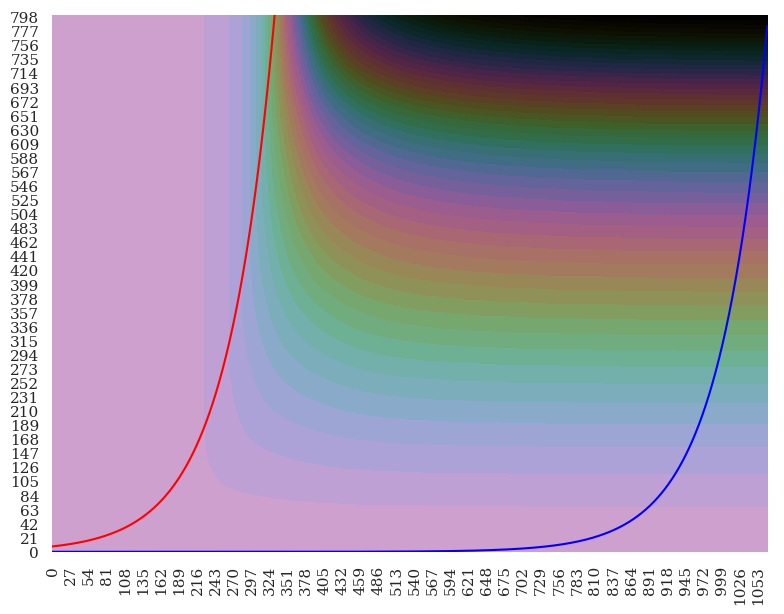

In [12]:
ax=sns.heatmap(F, cmap=mycmap, cbar=0, square=1)
ax.invert_yaxis()
plt.plot(range(0,right), boundary1, '-', markersize=1, color= 'blue')
plt.plot(range(0,right), boundary2, '-', markersize=1, color= 'red')
plt.tight_layout()

In [13]:
@nb.autojit(nopython=True)
def createZ(Z,F,right,freq,powr,fc): 
    FF=F/np.max(F)
    for i in range(0,100*fc+1):
        for j in range(0,right):
            num=0
            den=0
            for k in range(0,len(powr)):
                num+=np.power(FF[i,j],powr[k]-2)*freq[k]
                den+=np.power(FF[i,j],powr[k]-2)*freq[k]*(powr[k]-1)
            Z[i,j]=num/den

@nb.autojit(nopython=True)
def create3(Z,F,Fp1,Fp2,rhs,rhsfake,right,fc,scale,w): 
    for i in range(1,100*fc+1):
        q=i/fc
        aq=-100/np.power(q,w)
        myright=min(int(round(fc*scale*(w*np.log(q)+np.log(100)))),right)
        myleft=max(0,int(round(fc*scale*(w*np.log(q)))))
        for j in range(myleft,myright):
            th=-np.exp(np.log(100)-j/(fc*scale)) 
            if th>aq:
                den=-Fp2[i,j]+100*w*Z[i,j]*F[i,j]/((th-aq)*fc*np.power(q,w+1))
                if den!=0:
                    my=Fp1[i,j]/den
                    if my>=0 and my<5:
                        rhs[i,j]=my
                        rhsfake[i,j]=1
            rhs[0,0]=1/2
            rhs[0,1]=1/2
        
Z=np.zeros((100*fc+1,right),dtype=float) 
createZ(Z,F,right,freq,powr,fc)        
        
rhsfake=np.zeros((100*fc+1,right),dtype=float)                            
rhs=np.zeros((100*fc+1,right),dtype=float)
create3(Z,F,Fp1,Fp2,rhs,rhsfake,right,fc,scale,w)   

print(np.min(rhs),np.max(rhs))

0.0 4.999646189613012


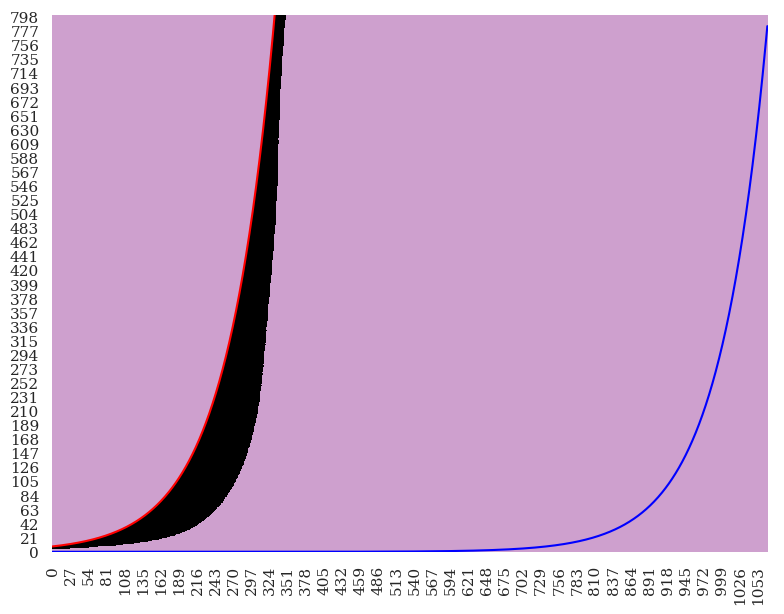

In [14]:
ax=sns.heatmap(rhsfake, cmap=mycmap, cbar=0, square=1)
ax.invert_yaxis()
plt.plot(range(0,right), boundary1, '-', markersize=1, color= 'blue')
plt.plot(range(0,right), boundary2, '-', markersize=1, color= 'red')
plt.tight_layout()

In [15]:
mydic={}

def myfun(x,y):
    return int2dslow(y,x,rhs)

myode=sp1.ode(myfun, jac=None)

y0=1*fc
x0=1

myode.set_initial_value(y0,x0)
myode.set_integrator('dopri5', nsteps=5000)

dt=0.5
x=[x0-2,x0-1]
y=[y0-2,y0-1]

while y[-1] < 100*fc+1 and x[-1] < right:
    newy=myode.integrate(myode.t+dt)[0]
    if newy-y[-1]>10*dt or (newy==y[-1] and y[-1]>2*fc):
        x=x+[x[-1]]
        y=y+[y[-1]+dt]
        myode.set_initial_value(y[-1], x[-1])
    else:
        x=x+[myode.t+dt]
        y=y+[newy]

mydic[int(round(1000*w))]=[np.array(x),np.array(y)]

fstrat = sp2.interp1d([0]+list(x),[0]+list(y))
fstrat_inv = sp2.interp1d([0]+list(y),[0]+list(x))

ymax=int(max(y))
#print('ymax=',ymax)

xmax=int(max(x))
#print('xmax=',xmax)

myinv=[]
for i in range(0,ymax):
    myinv+=[int(fstrat_inv(i))]
myinv=np.array(myinv)

myfor=[]
for i in range(0,xmax):
    myfor+=[int(fstrat(i))]
myfor=np.array(myfor)

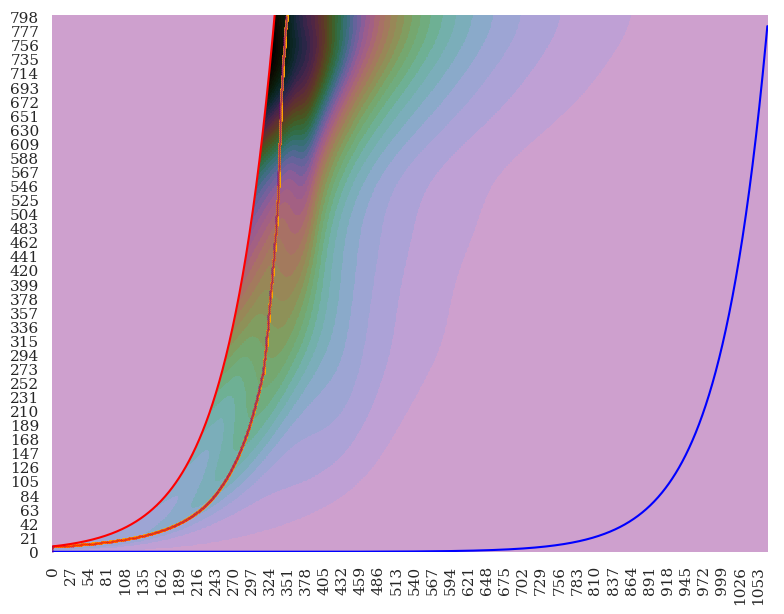

In [16]:
ax=sns.heatmap(dist_qth, cmap=mycmap, cbar=0, square=1)
ax.invert_yaxis()
plt.plot(np.array(x), np.array(y), 'ro', markersize=1, color= 'orange')
plt.plot(range(0,right), boundary1, '-', markersize=1, color= 'blue')
plt.plot(range(0,right), boundary2, '-', markersize=1, color= 'red')
plt.plot(range(0,xmax),[myfor[i] for i in range(0,xmax)], 'ro', markersize=0.2, color= 'red')
plt.plot([myinv[i] for i in range(0,ymax)], range(0,ymax), 'ro', markersize=0.2, color= 'purple')
plt.tight_layout()

In [17]:
@nb.autojit(nopython=True)
def create8(reflect7,reflect8,myinv,myfor,F,xmax,ymax,fc,right): 
    for i in range(1,100*fc+1):
        q=i/fc
        aq=-100/np.power(q,w)
        myright=min(int(round(fc*scale*(w*np.log(q)+np.log(100)))),right)
        myleft=max(0,int(round(fc*scale*(w*np.log(q)))))
        for j in range(myleft,myright):
            if i<ymax:
                if j<xmax:
                    inv=myinv[i]
                    if inv>=j:
                        reflect8[i,j]=F[i,inv]
                    else:
                        reflect8[i,j]=F[myfor[j],j]
                else:
                    reflect8[i,j]=F[100*fc,j]
            else:
                reflect8[i,j]=F[i,right-1]
                
dist_pseudo=np.zeros((100*fc+1,right),dtype=float)

create8(dist_qth,dist_pseudo,myinv,myfor,F,xmax,ymax,fc,right)
dist_pseudo=dist_pseudo/np.max(dist_pseudo)

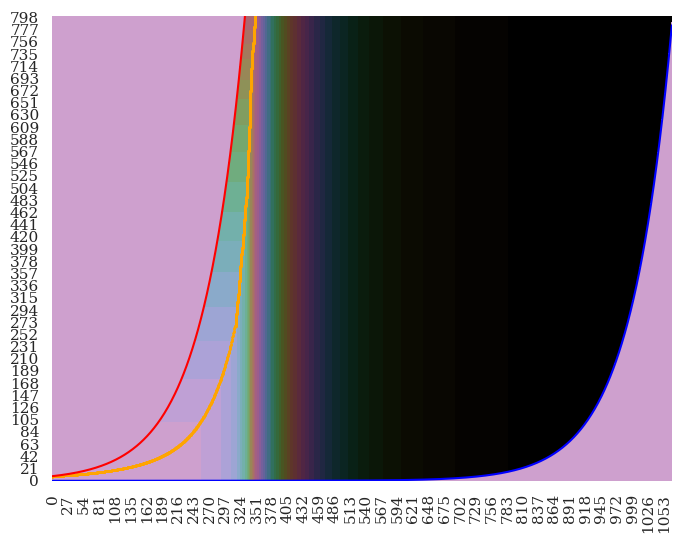

In [18]:
ax=sns.heatmap(dist_pseudo, cmap=mycmap, cbar=0, square=1)
plt.plot(np.array(x), np.array(y), 'ro', markersize=1, color= 'orange')
plt.plot(range(0,right), boundary1, '-', markersize=1, color= 'blue')
plt.plot(range(0,right), boundary2, '-', markersize=1, color= 'red')
ax.invert_yaxis()

In [19]:
@nb.autojit(nopython=True)
def create9(reflect8,reflect9, l, powers, frequencies, right, fc): 
    for k in range(0,l):
        pk=powers[k]-1
        fk=frequencies[k]
        for i in range(0,100*fc+1):
            myright=right#i+int(round(100*fc*ww))
            for j in range(0,myright):
                reflect9[i,j]+=(reflect8[i,j]**pk)*fk
                
frequencies=np.array(PART[1])/np.sum(PART[1])
powers=np.array(PART[0])
l=len(powers)    

num=0
for i in range(0,len(powers)):
    num+=powers[i]*frequencies[i]
    
print('num=',num)

dist_power=np.zeros((100*fc+1,right),dtype=float)

create9(dist_pseudo,dist_power, l ,powers, frequencies, right, fc)

print(np.max(dist_power))

num= 2.865771812080537
1.0


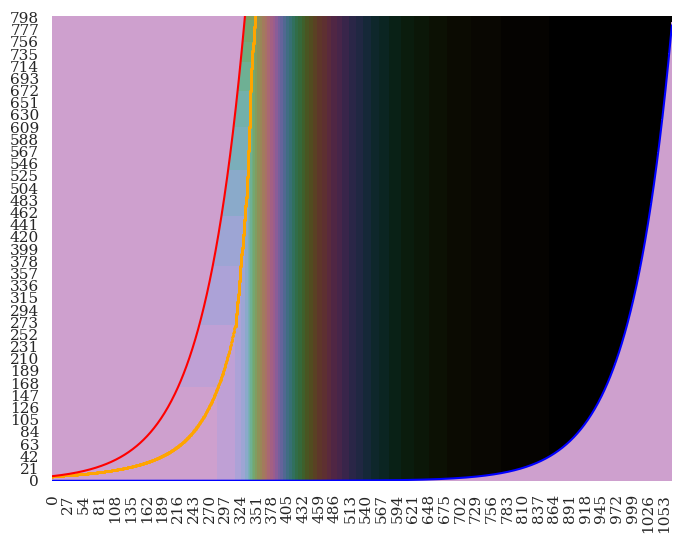

In [20]:
ax=sns.heatmap(dist_power, cmap=mycmap, cbar=0, square=1)
plt.plot(np.array(x), np.array(y), 'ro', markersize=1, color= 'orange')
plt.plot(range(0,right), boundary1, '-', markersize=1, color= 'blue')
plt.plot(range(0,right), boundary2, '-', markersize=1, color= 'red')
ax.invert_yaxis()

In [21]:
@nb.autojit(nopython=True)
def myhelp(rrr, qqq, fc, scale, w, right): 
    for i in range(1,100*fc+1):
        q=i/fc
        myright=min(int(round(fc*scale*(w*np.log(q)+np.log(100)))),right)
        myleft=max(0,int(round(fc*scale*(w*np.log(q)))))
        for j in range(myleft,myright):
            rrr[i,j]=np.power(q,w)
            qqq[i,j]=q 

@nb.autojit(nopython=True)
def createR(reflect9,reflect9help,reflect9help2,rebate,myinv,right,fc,scale): 
    end=min(100*fc+1,len(myinv))
    for i in range(1,end):
        q=i/fc
        aq=-100/np.power(q,w)
        myright=right
        for j in range(0,myright-1):
            jloc=j/(fc*scale)
            for k in range(j,myright-1):
                reflect9help2[i,k+1]+=np.exp(np.log(100)-jloc)*reflect9help[i,j]/(fc*scale)
        for j in range(0,myright):
            th=-np.exp(np.log(100)-j/(fc*scale)) 
            rebate[i,j]=max((th-aq)*reflect9[i,j]-reflect9help2[i,j],0)
            
rrr=np.zeros((100*fc+1,right),dtype=float)      
qqq=np.zeros((100*fc+1,right),dtype=float)

myhelp(rrr, qqq, fc, scale, w, right)

quality=np.multiply(dist_power,qqq)

rebate=np.zeros((100*fc+1,right),dtype=float)

dist_power_help=dist_power.copy()
dist_power_help2=np.zeros((100*fc+1,right),dtype=float)

createR(dist_power,dist_power_help,dist_power_help2,rebate,myinv,right,fc,scale)

rebate=np.multiply(rebate,rrr)

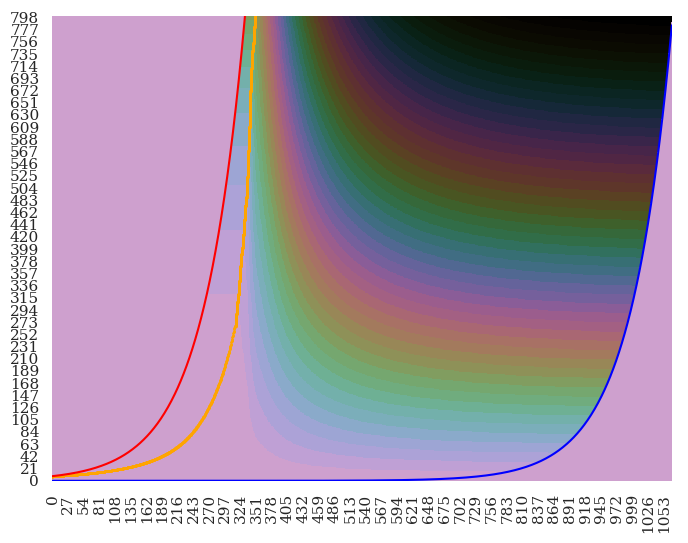

In [22]:
ax=sns.heatmap(quality, cmap=mycmap, cbar=0, square=1)
plt.plot(np.array(x), np.array(y), 'ro', markersize=1, color= 'orange')
plt.plot(range(0,right), boundary1, '-', markersize=1, color= 'blue')
plt.plot(range(0,right), boundary2, '-', markersize=1, color= 'red')
ax.invert_yaxis()

0.0 87.23050437654433


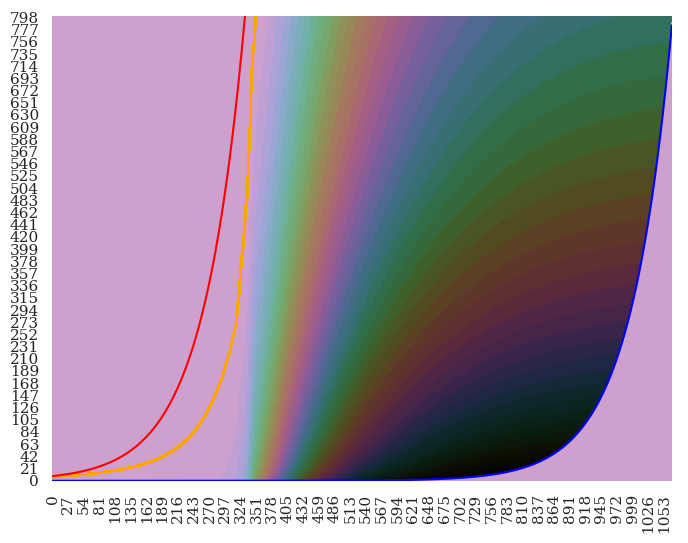

In [23]:
ax=sns.heatmap(rebate, cmap=mycmap, cbar=0, square=1)
ax.invert_yaxis()
plt.plot(np.array(x), np.array(y), 'ro', markersize=1, color= 'orange')
plt.plot(range(0,right), boundary1, '-', markersize=1, color= 'blue')
plt.plot(range(0,right), boundary2, '-', markersize=1, color= 'red')

print(np.min(rebate),np.max(rebate))

In [24]:
@nb.autojit(nopython=True)
def mymultiply(reflect9,rebate,quality): 
    mysum=np.sum(reflect9)
    EQ=np.sum(np.multiply(reflect9,quality))/mysum
    ER=np.sum(np.multiply(reflect9,rebate))/mysum
    return ER,EQ

In [25]:
ER,EQ=mymultiply(dist_qth,rebate,quality)
print('\n w=',w,':',num*ER,num*EQ)


 w= 0.45 : 34.52039310517116 85.35477509714693
